**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [1]:
#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [2]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# you need to obtain Wang's features from his notebook
df_train = pd.read_csv('df_train_2_extra.csv')
df_test = pd.read_csv('df_test_2_extra.csv')
# df_train=pd.read_csv("train_wang_pur_date_4.csv")
# df_test=pd.read_csv("test_wang_pur_date_4.csv")

In [5]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [7]:
len(df_train_columns)
len(exclude_features)

4

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [8]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [9]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [10]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.226000e+06,288,3.573874
62,auth_hist_month_nunique,1.290806e+06,239,3.573874
181,new_hist_purchase_amount_max,7.555856e+05,197,3.573874
196,new_hist_month_lag_mean,4.656750e+05,160,3.573874
91,auth_hist_month_diff_mean,1.034717e+06,146,3.573874


In [11]:
actual_imp_df1=actual_imp_df.copy()

In [12]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.226000e+06,288,3.573874
62,auth_hist_month_nunique,1.290806e+06,239,3.573874
181,new_hist_purchase_amount_max,7.555856e+05,197,3.573874
196,new_hist_month_lag_mean,4.656750e+05,160,3.573874
91,auth_hist_month_diff_mean,1.034717e+06,146,3.573874


In [13]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.226000e+06,288,3.573874
62,auth_hist_month_nunique,1.290806e+06,239,3.573874
181,new_hist_purchase_amount_max,7.555856e+05,197,3.573874
196,new_hist_month_lag_mean,4.656750e+05,160,3.573874
91,auth_hist_month_diff_mean,1.034717e+06,146,3.573874


In [14]:
import time

In [16]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  14.7 min)

In [17]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_2_extra.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_2extra.csv')

In [18]:
#actual_imp_df=feature_importance

In [19]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [20]:
import matplotlib.gridspec as gridspec
import seaborn as sns

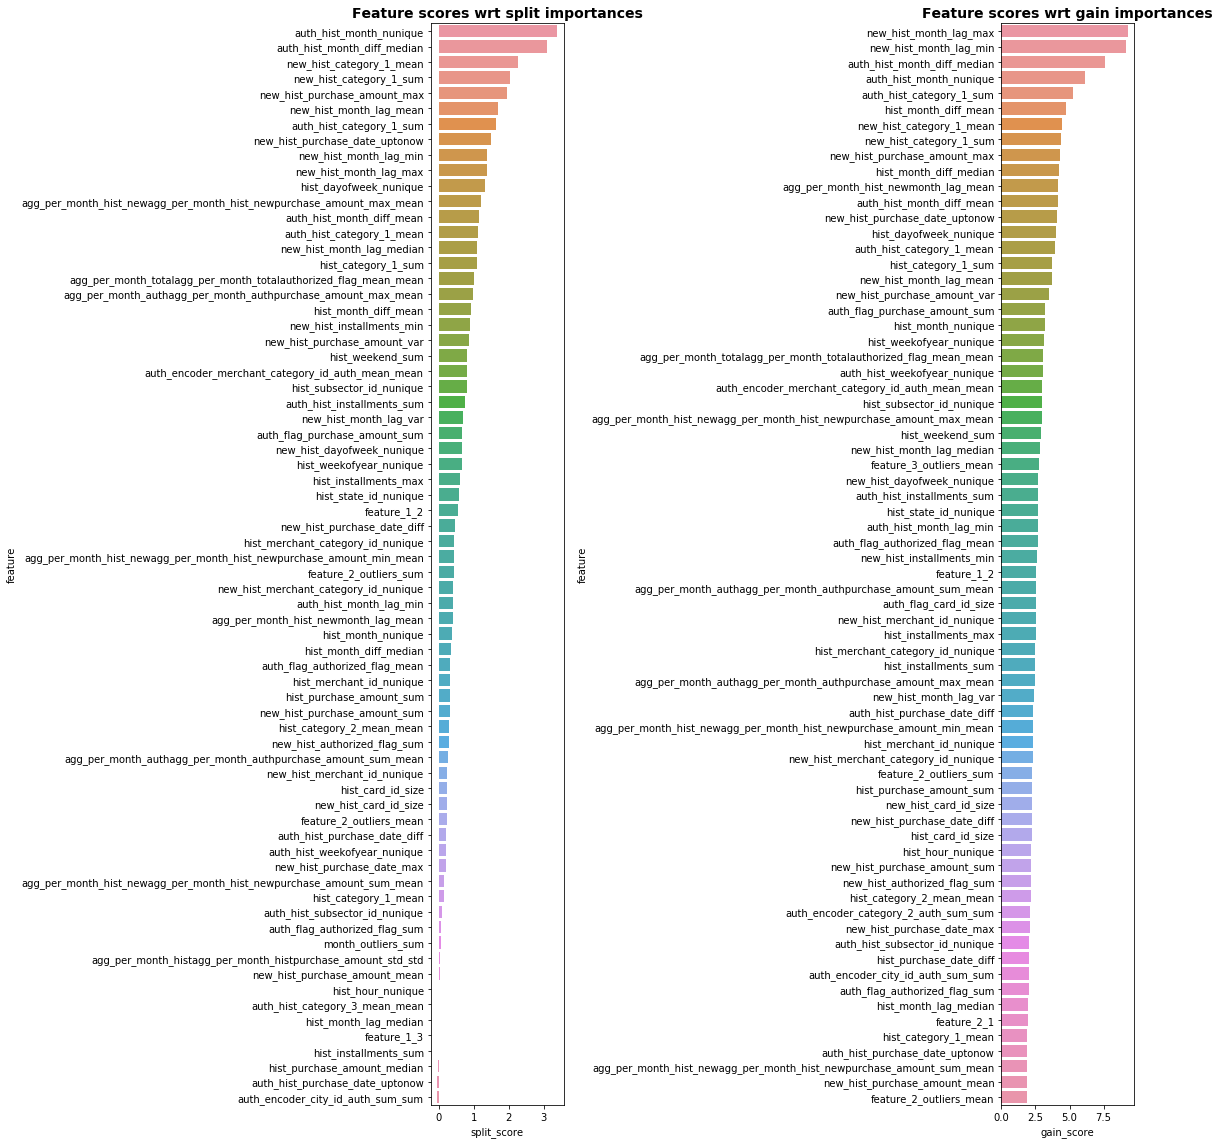

In [21]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

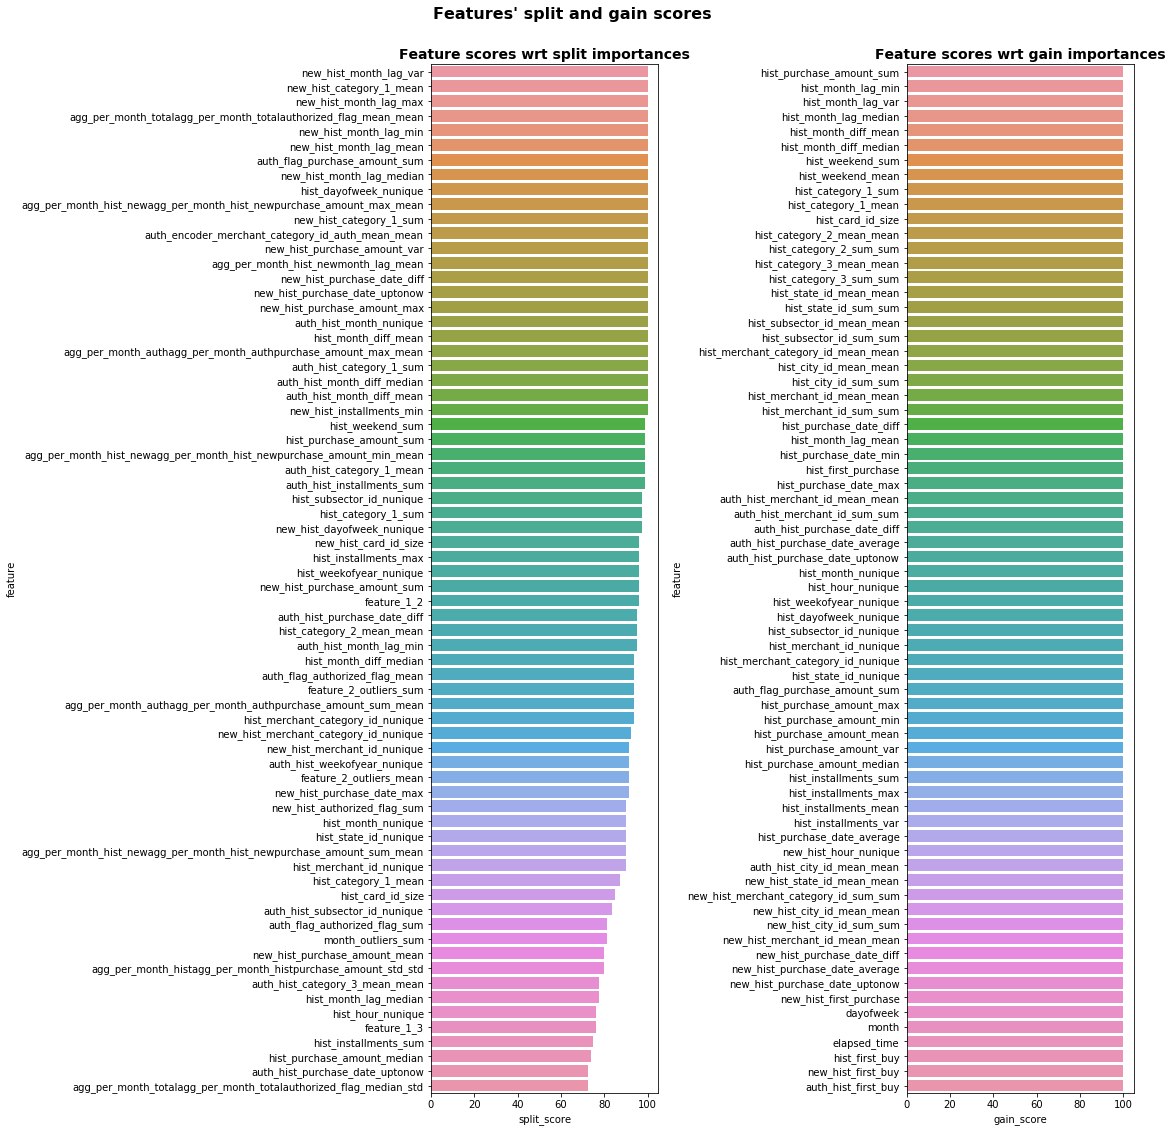

In [22]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [23]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

253
140
125
111
98
87
78
71
62
55
40
24


250
131
120
110
103
91
77
70
63
49
42
21

In [24]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    
    dtrain = lgb.Dataset(df.loc[:,train_features], target, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last
    
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

    
    

Results for threshold   0
	 SPLIT : 3.647590 +/- 0.036224
	 GAIN  : 3.647976 +/- 0.036363
Results for threshold  10
	 SPLIT : 3.644733 +/- 0.037247
	 GAIN  : 3.648445 +/- 0.037327
Results for threshold  20
	 SPLIT : 3.643215 +/- 0.036726
	 GAIN  : 3.648799 +/- 0.036129
Results for threshold  30
	 SPLIT : 3.644804 +/- 0.037022
	 GAIN  : 3.648572 +/- 0.035442
Results for threshold  40
	 SPLIT : 3.642583 +/- 0.036469
	 GAIN  : 3.649581 +/- 0.035796
Results for threshold  50
	 SPLIT : 3.642769 +/- 0.036404
	 GAIN  : 3.648459 +/- 0.037615
Results for threshold  60
	 SPLIT : 3.643193 +/- 0.037339
	 GAIN  : 3.649065 +/- 0.036335
Results for threshold  70
	 SPLIT : 3.645077 +/- 0.036316
	 GAIN  : 3.647978 +/- 0.037054
Results for threshold  80
	 SPLIT : 3.645945 +/- 0.036604
	 GAIN  : 3.649186 +/- 0.037054
Results for threshold  90
	 SPLIT : 3.647475 +/- 0.037438
	 GAIN  : 3.648927 +/- 0.036650
Results for threshold  95
	 SPLIT : 3.649836 +/- 0.037840
	 GAIN  : 3.648477 +/- 0.035420
Results fo

In [25]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.6471432149350647
	 GAIN  : 3.6464034787100843
Results for threshold  10
	 SPLIT : 3.6430458556854446
	 GAIN  : 3.6451558623539224
Results for threshold  20
	 SPLIT : 3.640736467995538
	 GAIN  : 3.646030279376511
Results for threshold  30
	 SPLIT : 3.6423888106009477
	 GAIN  : 3.646466201500767
Results for threshold  40
	 SPLIT : 3.640605928927936
	 GAIN  : 3.6443701003525173
Results for threshold  50
	 SPLIT : 3.6420222527458246
	 GAIN  : 3.6456373151892163
Results for threshold  60
	 SPLIT : 3.6432501343508186
	 GAIN  : 3.645219449282708
Results for threshold  70
	 SPLIT : 3.643615324498084
	 GAIN  : 3.646181387127601
Results for threshold  80
	 SPLIT : 3.641867143406265
	 GAIN  : 3.645119721614717
Results for threshold  90
	 SPLIT : 3.6478026672317645
	 GAIN  : 3.645961517586147
Results for threshold  95
	 SPLIT : 3.6480499087821894
	 GAIN  : 3.645965817137826
Results for threshold  99
	 SPLIT : 3.6546764412973927
	 GAIN  : 3.644642553575464


In [26]:
split_results_list

[3.6471432149350647,
 3.6430458556854446,
 3.640736467995538,
 3.6423888106009477,
 3.640605928927936,
 3.6420222527458246,
 3.6432501343508186,
 3.643615324498084,
 3.641867143406265,
 3.6478026672317645,
 3.6480499087821894,
 3.6546764412973927]

In [27]:
str(split_results)

'3.6546764412973927'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [28]:
corr_scores_df.to_csv('correlation_feature_scores_2extra.csv')

In [29]:
split_results

3.6546764412973927

In [30]:
for i in [10,20,30,40,50,60,70]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_2extra.csv',index=False)


In [33]:
corr_scores_df.sort_values('split_score',ascending=False).feature.head(50)

197                               new_hist_month_lag_var
207                             new_hist_category_1_mean
194                               new_hist_month_lag_max
22     agg_per_month_totalagg_per_month_totalauthoriz...
195                               new_hist_month_lag_min
196                              new_hist_month_lag_mean
1                          auth_flag_purchase_amount_sum
198                            new_hist_month_lag_median
119                               hist_dayofweek_nunique
58     agg_per_month_hist_newagg_per_month_hist_newpu...
206                              new_hist_category_1_sum
14      auth_encoder_merchant_category_id_auth_mean_mean
184                         new_hist_purchase_amount_var
50                  agg_per_month_hist_newmonth_lag_mean
223                          new_hist_purchase_date_diff
225                       new_hist_purchase_date_uptonow
181                         new_hist_purchase_amount_max
62                             

### Now let's try with some features from merchant and historical transactions

In [34]:
data=pd.read_csv('merchants_map.csv')

In [35]:
df_train=df_train.merge(data,on='card_id')
df_test=df_test.merge(data,on='card_id')

In [36]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [38]:

len(df_train_columns),len(exclude_features)

(259, 4)

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [39]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [40]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [41]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.195104e+06,277,3.572898
62,auth_hist_month_nunique,1.218661e+06,218,3.572898
181,new_hist_purchase_amount_max,7.759120e+05,199,3.572898
196,new_hist_month_lag_mean,4.606134e+05,162,3.572898
91,auth_hist_month_diff_mean,1.051470e+06,145,3.572898


In [42]:
actual_imp_df1=actual_imp_df.copy()

In [43]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.195104e+06,277,3.572898
62,auth_hist_month_nunique,1.218661e+06,218,3.572898
181,new_hist_purchase_amount_max,7.759120e+05,199,3.572898
196,new_hist_month_lag_mean,4.606134e+05,162,3.572898
91,auth_hist_month_diff_mean,1.051470e+06,145,3.572898


In [44]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
225,new_hist_purchase_date_uptonow,1.195104e+06,277,3.572898
62,auth_hist_month_nunique,1.218661e+06,218,3.572898
181,new_hist_purchase_amount_max,7.759120e+05,199,3.572898
196,new_hist_month_lag_mean,4.606134e+05,162,3.572898
91,auth_hist_month_diff_mean,1.051470e+06,145,3.572898


In [45]:
import time

In [46]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  14.5 min)

In [47]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref_8extra.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref_8extra.csv')

In [48]:
#actual_imp_df=feature_importance

In [49]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [50]:
import matplotlib.gridspec as gridspec
import seaborn as sns

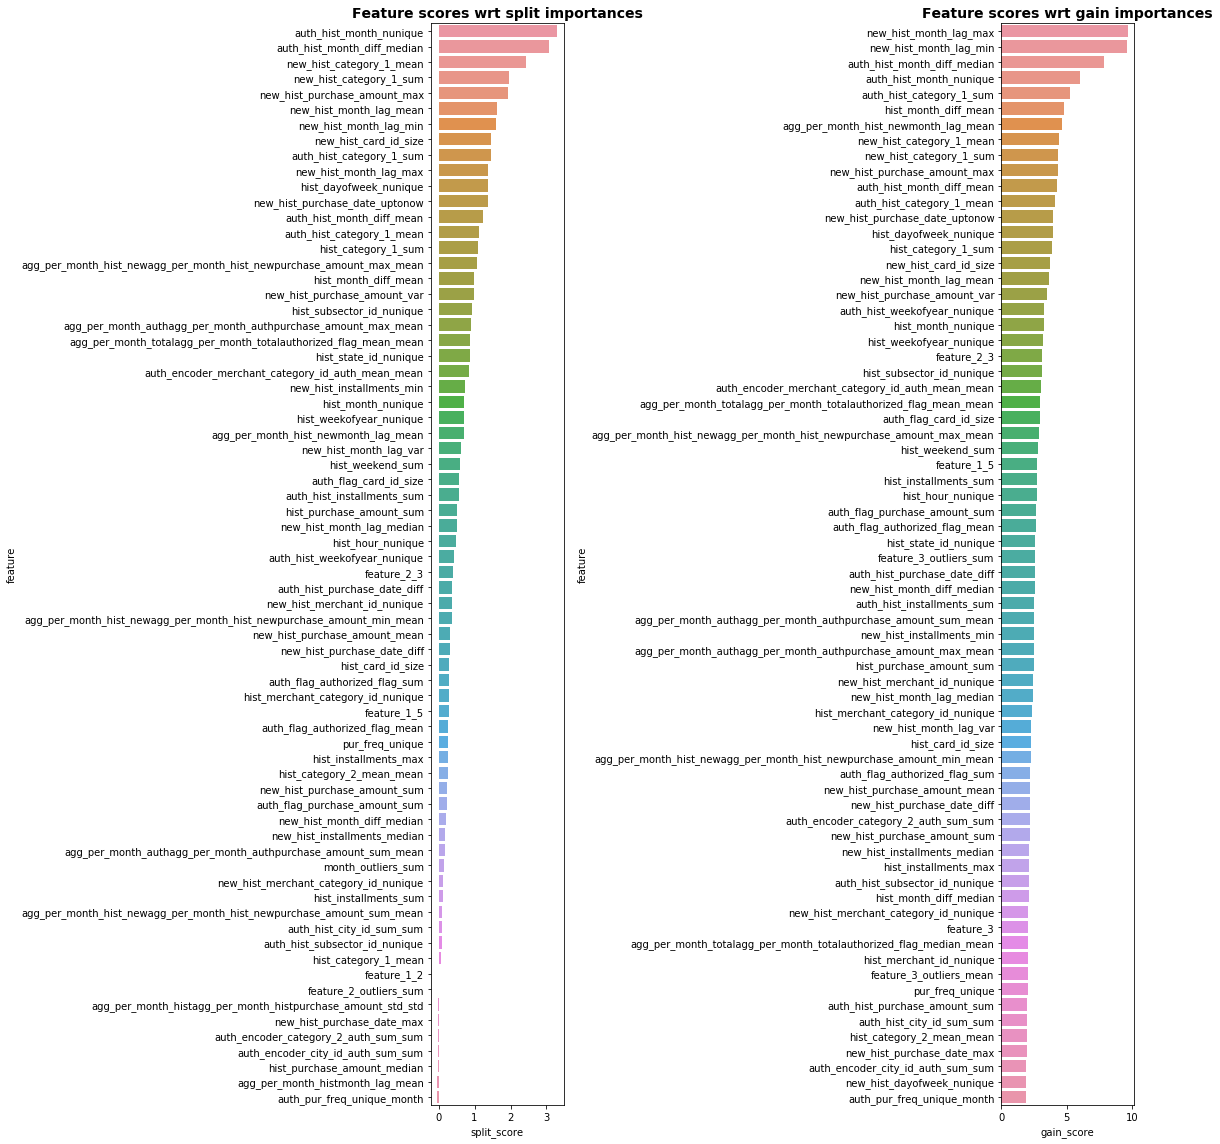

In [51]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

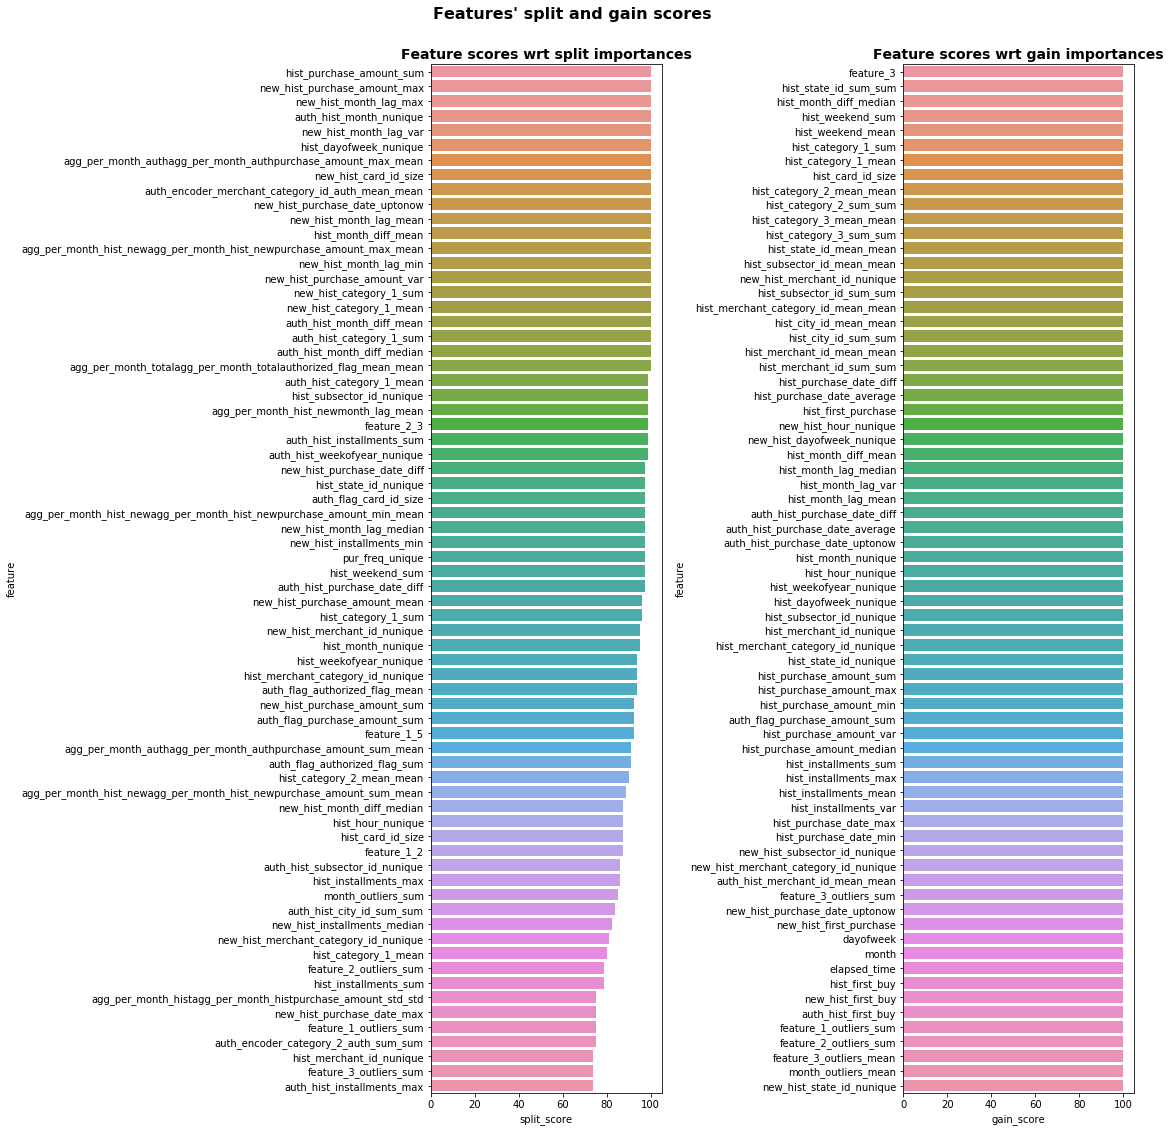

In [52]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [53]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

259
152
136
125
111
100
86
76
61
49
40
21


250
131
120
110
103
91
77
70
63
49
42
21

In [54]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    
    dtrain = lgb.Dataset(df.loc[:,train_features], target, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last
    
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

    
    

Results for threshold   0
	 SPLIT : 3.647143 +/- 0.036158
	 GAIN  : 3.647340 +/- 0.036057
Results for threshold  10
	 SPLIT : 3.644160 +/- 0.036715
	 GAIN  : 3.646661 +/- 0.035464
Results for threshold  20
	 SPLIT : 3.641907 +/- 0.036186
	 GAIN  : 3.647020 +/- 0.035896
Results for threshold  30
	 SPLIT : 3.641378 +/- 0.036599
	 GAIN  : 3.646904 +/- 0.036505
Results for threshold  40
	 SPLIT : 3.642176 +/- 0.036153
	 GAIN  : 3.646773 +/- 0.037275
Results for threshold  50
	 SPLIT : 3.642447 +/- 0.037266
	 GAIN  : 3.646214 +/- 0.035460
Results for threshold  60
	 SPLIT : 3.643045 +/- 0.036216
	 GAIN  : 3.647561 +/- 0.036604
Results for threshold  70
	 SPLIT : 3.642724 +/- 0.036207
	 GAIN  : 3.646087 +/- 0.037045
Results for threshold  80
	 SPLIT : 3.643505 +/- 0.037094
	 GAIN  : 3.646212 +/- 0.035859
Results for threshold  90
	 SPLIT : 3.645634 +/- 0.036057
	 GAIN  : 3.646756 +/- 0.036603
Results for threshold  95
	 SPLIT : 3.644859 +/- 0.036602
	 GAIN  : 3.647222 +/- 0.038052
Results fo

In [55]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.644318262697095
	 GAIN  : 3.644212642375459
Results for threshold  10
	 SPLIT : 3.6413494846871486
	 GAIN  : 3.6422212543173895
Results for threshold  20
	 SPLIT : 3.6399499359296814
	 GAIN  : 3.64415422246925
Results for threshold  30
	 SPLIT : 3.6399996124250973
	 GAIN  : 3.644146833597965
Results for threshold  40
	 SPLIT : 3.6402238145858608
	 GAIN  : 3.6442353531419656
Results for threshold  50
	 SPLIT : 3.6403751260706017
	 GAIN  : 3.6441542659098394
Results for threshold  60
	 SPLIT : 3.6396033848361595
	 GAIN  : 3.6445386201531877
Results for threshold  70
	 SPLIT : 3.639728979643404
	 GAIN  : 3.645593835468556
Results for threshold  80
	 SPLIT : 3.6424103544286837
	 GAIN  : 3.6440253208322373
Results for threshold  90
	 SPLIT : 3.6446596676156457
	 GAIN  : 3.6441947950802684
Results for threshold  95
	 SPLIT : 3.6444245911236357
	 GAIN  : 3.6448843100757093
Results for threshold  99
	 SPLIT : 3.6559742692001125
	 GAIN  : 3.642983908190117


In [56]:
split_results_list

[3.644318262697095,
 3.6413494846871486,
 3.6399499359296814,
 3.6399996124250973,
 3.6402238145858608,
 3.6403751260706017,
 3.6396033848361595,
 3.639728979643404,
 3.6424103544286837,
 3.6446596676156457,
 3.6444245911236357,
 3.6559742692001125]

In [57]:
str(split_results)

'3.6559742692001125'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [58]:
corr_scores_df.to_csv('correlation_feature_scores_8extra.csv')

In [59]:
split_results

3.6559742692001125

In [60]:
for i in [10,20,30,40,50,60,70]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'_8extra.csv',index=False)
